In [1]:
import os
import re
import sys

import h5py
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks')


In [2]:
#Load westminster scripts (gtex coefficient helper functions)

sys.path.append('/home/drk/code/westminster/src/westminster/scripts/')
from westminster_gtex_coef import read_eqtl
from westminster_gtex_coef import read_scores as read_borzoi


In [3]:
#Define folders with SNP predictions

gtex_vcf_dir = '/home/drk/seqnn/data/gtex_fine/susie_pip90'
borzoi_dir = '/home/drk/seqnn/data/models/v2'
borzoi_gtex_dir = '%s/ensemble/gtexu' % borzoi_dir


In [4]:
# Enformer supplement
# tissue_keywords = {
#     'Adipose_Subcutaneous': 'adipose',
#     'Esophagus_Mucosa': 'esophagus',
#     'Skin_Not_Sun_Exposed_Suprapubic': 'skin',
#     'Testis': 'testis',
#     'Thyroid': 'thyroid',
#     'Whole_Blood': 'blood',
# }

# Extended set of tissues
tissue_keywords = {
      'Adipose_Subcutaneous': 'adipose',
      'Breast_Mammary_Tissue': 'breast',
      'Colon_Transverse': 'colon',
      'Esophagus_Mucosa': 'esophagus',
      'Liver': 'liver',
      'Lung': 'lung',
      'Muscle_Skeletal': 'muscle',
      'Ovary': 'ovary',
      'Pancreas': 'pancreas',
      'Pituitary': 'pituitary',
      'Prostate': 'prostate',
      'Skin_Not_Sun_Exposed_Suprapubic': 'skin',
      'Spleen': 'spleen',
      'Testis': 'testis',
      'Thyroid': 'thyroid',
      'Whole_Blood': 'blood'
}

#Function to get Enformer output indices per tissue
def enformer_track(tissue: str):
    """Return the ENFORMER track for the given tissue."""
    tissue_ti = {
        'Adipose_Subcutaneous': 4678,
        'Breast_Mammary_Tissue': 4976,
        'Cells_EBV-transformed_lymphocytes': 5110,
        'Colon_Transverse': 4978,
        'Esophagus_Mucosa': 4683,
        'Heart_Left_Ventricle': 4974,
        'Liver': 4686,
        'Lung': 4687,
        'Minor_Salivary_Gland': 4911,
        'Muscle_Skeletal': 4691,
        'Ovary': 4688,
        'Pancreas': 4946,
        'Pituitary': 5270,
        'Prostate': 4690,
        'Skin_Not_Sun_Exposed_Suprapubic': 4970,
        'Small_Intestine_Terminal_Ileum': 4692,
        'Spleen': 4693,
        'Testis': 4694,
        'Thyroid': 4696,
        'Uterus': 4910,
        'Vagina': 5175,
        'Whole_Blood': 4950
    }
    
    return tissue_ti[tissue]


In [5]:
#Function to read predictions from Enformer files and extract tissue scores
def read_enformer(tissue: str, eqtl_df):
    """Read Enformer eQTL predictions for the given tissue."""
    
    dm_sad_file = '/home/drk/attn/analysis/2020/6-16/dm37_fr/%s_pos/sad.h5' % tissue
    tti = enformer_track(tissue)
    
    #Load file with predictions
    with h5py.File(dm_sad_file, 'r') as dm_sad_h5:
        
        #Decode variant effects predictions
        sad_ref = np.array([ref.decode('UTF-8') for ref in dm_sad_h5['ref']])
        variant_scores = dm_sad_h5['SAD'][...,tti]
        variant_scores = np.arcsinh(variant_scores)

    #Flip incorrect alleles (relative to hg38)
    sad_flip = (sad_ref != eqtl_df.allele)
    variant_scores[sad_flip] = -variant_scores[sad_flip]

    return variant_scores


In [6]:
#Append Borzoi and Enformer Spearman correlation metrics

metrics_tissue = []
metrics_method = []
metrics_r = []

#Loop over tissues and prediction keywords
for tissue, keyword in tissue_keywords.items():
    print(tissue)

    #Read causal variants
    eqtl_df = read_eqtl(tissue, gtex_vcf_dir)
    variant_coef = eqtl_df[eqtl_df.consistent].coef
    
    ################################
    #Read Enformer predictions
    gtex_scores_file = f'{borzoi_gtex_dir}/{tissue}_pos/sad.h5'
    enformer_scores = read_enformer(tissue, eqtl_df)
    enformer_scores = enformer_scores[eqtl_df.consistent]

    #Compute Spearman correlation
    enformer_r = spearmanr(variant_coef, enformer_scores)[0]

    #Append tissues and correlation metrics
    metrics_tissue.append(tissue)
    metrics_method.append('Enformer')
    metrics_r.append(enformer_r)
    
    ################################
    #Read Borzoi predictions
    gtex_scores_file = f'{borzoi_gtex_dir}/{tissue}_pos/sad.h5'
    borzoi_scores = read_borzoi(gtex_scores_file, keyword, eqtl_df, 'logSAD')
    borzoi_scores = borzoi_scores[eqtl_df.consistent]

    #Compute Spearman correlation
    borzoi_r = spearmanr(variant_coef, borzoi_scores)[0]

    #Append tissues and correlation metrics
    metrics_tissue.append(tissue)
    metrics_method.append('Borzoi')
    metrics_r.append(borzoi_r)


Adipose_Subcutaneous
Breast_Mammary_Tissue
Colon_Transverse
Esophagus_Mucosa
Liver
Lung
Muscle_Skeletal
Ovary
Pancreas
Pituitary
Prostate
Skin_Not_Sun_Exposed_Suprapubic
Spleen
Testis
Thyroid
Whole_Blood


In [7]:
#Construct dataframe with metrics

metrics_df = pd.DataFrame({
    'tissue': metrics_tissue,
    'method': metrics_method,
    'spearmanr': metrics_r
})

#Print summary
metrics_enformer_df = metrics_df[metrics_df.method=='Enformer']
metrics_borzoi_df = metrics_df[metrics_df.method=='Borzoi']

print('Enformer: %.4f' % metrics_enformer_df.spearmanr.mean())
print('Borzoi:   %.4f' % metrics_borzoi_df.spearmanr.mean())


Enformer: 0.2272
Borzoi:   0.3338


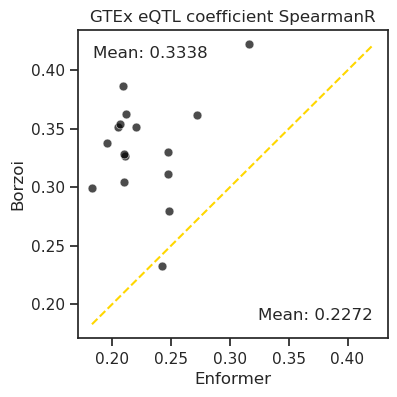

In [8]:
#Plot eQTL coefficient correlations (Borzoi vs Enformer)

plt.figure(figsize=(4,4))
plt.title('GTEx eQTL coefficient SpearmanR')
sns.scatterplot(x=metrics_enformer_df.spearmanr.values,
                y=metrics_borzoi_df.spearmanr.values,
                color='black', alpha=0.7, s=40)
ax = plt.gca()

ax.text(0.95, 0.05, 'Mean: %.4f' % metrics_enformer_df.spearmanr.mean(), 
                horizontalalignment='right', verticalalignment='bottom',
                transform=ax.transAxes)
ax.text(0.05, 0.95, 'Mean: %.4f' % metrics_borzoi_df.spearmanr.mean(), 
                horizontalalignment='left', verticalalignment='top',
                transform=ax.transAxes)

vmin = min(metrics_enformer_df.spearmanr.min(), metrics_borzoi_df.spearmanr.min())
vmax = max(metrics_enformer_df.spearmanr.max(), metrics_borzoi_df.spearmanr.max())
ax.plot([vmin,vmax], [vmin,vmax], linestyle='--', c='gold')

ax.set_xlabel('Enformer')
ax.set_ylabel('Borzoi')

plt.savefig('eqtl_coef_scatter.pdf')


In [9]:
#Print list of Spearman correlation metrics
metrics_borzoi_df.sort_values('spearmanr')


,tissue,method,spearmanr
27,Testis,Borzoi,0.232936
13,Muscle_Skeletal,Borzoi,0.279896
21,Prostate,Borzoi,0.299502
29,Thyroid,Borzoi,0.304366
9,Liver,Borzoi,0.311126
1,Adipose_Subcutaneous,Borzoi,0.326619
23,Skin_Not_Sun_Exposed_Suprapubic,Borzoi,0.327983
7,Esophagus_Mucosa,Borzoi,0.330397
5,Colon_Transverse,Borzoi,0.338063
3,Breast_Mammary_Tissue,Borzoi,0.351365


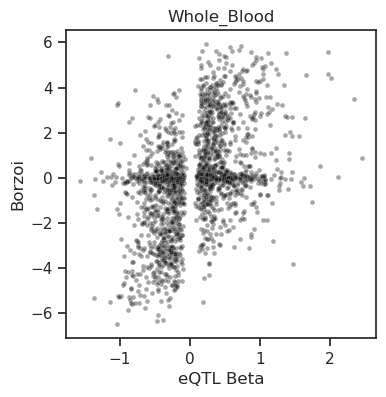

In [10]:
#Plot coefficient predictions for example tissue
tissue = 'Whole_Blood'

#Read causal variants
eqtl_df = read_eqtl(tissue, gtex_vcf_dir)
variant_coef = eqtl_df[eqtl_df.consistent].coef

#Read Borzoi
gtex_scores_file = f'{borzoi_gtex_dir}/{tissue}_pos/sad.h5'
borzoi_scores = read_borzoi(gtex_scores_file, keyword, eqtl_df, 'logSAD')
borzoi_scores = borzoi_scores[eqtl_df.consistent]

#Plot
plt.figure(figsize=(4,4))
plt.title(f'{tissue}')
sns.scatterplot(x=variant_coef,
                y=borzoi_scores,
                color='black', alpha=0.35, s=12)
ax = plt.gca()

ax.set_xlabel('eQTL Beta')
ax.set_ylabel('Borzoi')
plt.savefig('eqtl_coef_blood.pdf')
